# Ежедневый краткий отчет

In [43]:
import telegram
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import pandas as pd
import pandahouse as ph
from datetime import date, datetime, timedelta

In [2]:
connection = {'host': '***',
                      '***',
                      'user':'***', 
                      'password':'***'
                     }


In [3]:
query = '''
       SELECT toDate(time) as day, 
              uniq(post_id) as posts,
              countIf(action='view') as views, 
              countIf(action='like') as likes,
              round(countIf(action='like') / countIf(action='view'), 4) as ctr,
              uniq(user_id) as dau
       FROM {db}.feed_actions
       WHERE toDate(time) BETWEEN (DATE(NOW()) - INTERVAL 8 DAY) AND (DATE(NOW()) - INTERVAL 1 DAY)
       GROUP BY day
       
        '''
df = ph.read_clickhouse(query, connection = connection)
df['day'] = pd.to_datetime(df['day'])
df = df.astype({'views': int, 'likes': int, 'dau': int, 'posts': int})

df

,day,posts,views,likes,ctr,dau
0,2023-07-18,224,617487,124494,0.2016,18585
1,2023-07-19,230,636338,128885,0.2025,18260
2,2023-07-20,202,608339,121381,0.1995,18269
3,2023-07-21,178,529200,107074,0.2023,18641
4,2023-07-22,196,513026,100781,0.1964,19026
5,2023-07-23,181,626809,131364,0.2096,18760
6,2023-07-24,195,604637,128146,0.2119,18885
7,2023-07-25,233,737226,156523,0.2123,18708


In [48]:
def get_message(df):
    day = pd.to_datetime(date.today() - timedelta(days = 1))
    day_before = pd.to_datetime(date.today() - timedelta(days = 2))
    week_before = pd.to_datetime(date.today() - timedelta(days = 8))
    
    dau = df[df.day == day]['dau'].iloc[0]
    dau_db = df[df.day == day_before]['dau'].iloc[0]
    dau_wb = df[df.day == week_before]['dau'].iloc[0]
    to_dau_db = (dau -  dau_db) /  dau_db
    to_dau_wb = (dau - dau_wb) / dau_wb
    
    likes = df[df.day == day]['likes'].iloc[0]
    likes_db = df[df.day == day_before]['likes'].iloc[0]
    likes_wb = df[df.day == week_before]['likes'].iloc[0]
    to_likes_db = (likes - likes_db) / likes_db
    to_likes_wb = (likes - likes_wb) / likes_wb
    
    views = df[df.day == day]['views'].iloc[0]
    views_db = df[df.day == day_before]['views'].iloc[0]
    views_wb = df[df.day == week_before]['views'].iloc[0]
    to_views_db = (views - views_db) / views_db
    to_views_wb = (views - views_wb) / views_wb
    
    ctr = df[df.day == day]['ctr'].iloc[0]
    ctr_db = df[df.day == day_before]['ctr'].iloc[0]
    ctr_wb = df[df.day == week_before]['ctr'].iloc[0]
    to_ctr_db = (ctr - ctr_db ) 
    to_ctr_wb = (ctr - ctr_wb) 

    lpu = df[df.day == day]['likes'].iloc[0] / df[df.day == day]['dau'].iloc[0]
    lpu_db = df[df.day == day_before]['likes'].iloc[0] / df[df.day == day_before]['dau'].iloc[0]
    lpu_wb = df[df.day == week_before]['likes'].iloc[0] / df[df.day == week_before]['dau'].iloc[0]
    to_lpu_db = (lpu - lpu_db) / lpu_db
    to_lpu_wb = (lpu - lpu_wb) / lpu_wb
    
    lpp = df[df.day == day]['likes'].iloc[0] / df[df.day == day]['posts'].iloc[0]
    lpp_db = df[df.day == day_before]['likes'].iloc[0] / df[df.day == day_before]['posts'].iloc[0]
    lpp_wb = df[df.day == week_before]['likes'].iloc[0] / df[df.day == week_before]['posts'].iloc[0]
    to_lpp_db = (lpp - lpp_db) / lpp_db
    to_lpp_wb = (lpp - lpp_wb) / lpp_wb
    
    a = f'ОТЧЕТ за {day.date()}'
    
    b = f'👫DAU: {dau} ({to_dau_db:+.2%} ко дню назад, {to_dau_wb:+.2%} к неделе назад)'
    
    c = f'👀Views: {views} ({to_views_db:+.2%} ко дню назад, {to_views_wb:+.2%} к неделе назад)'
    
    d = f'❤Likes: {likes} ({to_likes_db:+.2%} ко дню назад, {to_likes_wb:+.2%} к неделе назад)'
    
    e = f'🎯CTR: {ctr:.2} ({to_ctr_db:+.2%} ко дню назад, {to_ctr_wb:+.2%} к неделе назад)'
    
    f = f'👤Likes per user: {lpu:.2f} ({to_lpu_db:+.2%} ко дню назад, {to_lpu_wb:+.2%} к неделе назад)'
    
    g = f'🖼Likes per post: {lpp:.2f} ({to_lpp_db:+.2%} ко дню назад, {to_lpp_wb:+.2%} к неделе назад)'

    message = '\n'.join([a, '\n', b, c, d, e, f, g])
    
    return message
    
    

get_message(df)

'ОТЧЕТ за 2023-07-25\n\n\n👫DAU: 18708 (-0.94% ко дню назад, +0.66% к неделе назад)\n👀Views: 737226 (+21.93% ко дню назад, +19.39% к неделе назад)\n❤Likes: 156523 (+22.14% ко дню назад, +25.73% к неделе назад)\n🎯CTR: 0.21 (+0.04% ко дню назад, +1.07% к неделе назад)\n👤Likes per user: 8.37 (+23.30% ко дню назад, +24.90% к неделе назад)\n🖼Likes per post: 671.77 (+2.22% ко дню назад, +20.87% к неделе назад)'

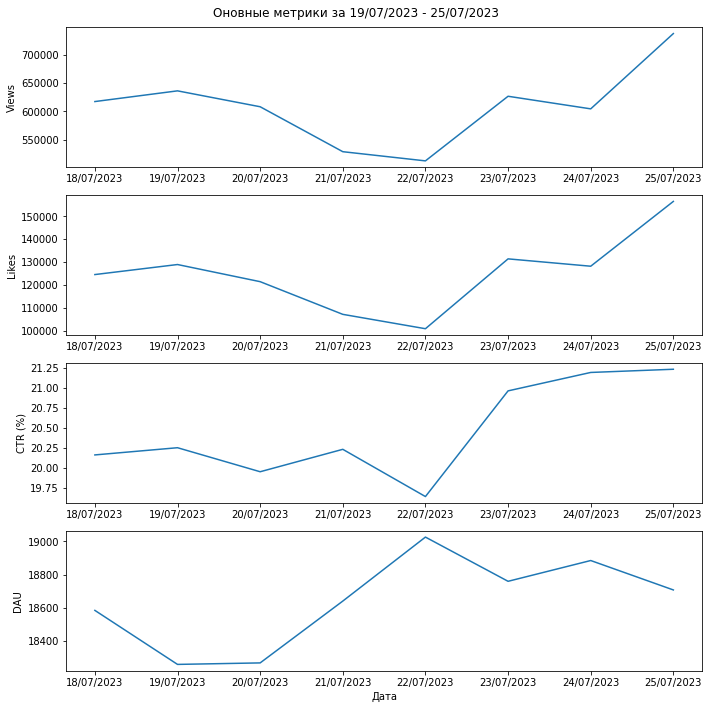

In [50]:
yesterday = date.today() - timedelta(days = 1)
start = (date.today() - timedelta(days = 7)).strftime("%d/%m/%Y")
yesterday_f = yesterday.strftime("%d/%m/%Y")
dates = [i.strftime("%d/%m/%Y") for i in pd.to_datetime(df['day'])]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10,10))
sns.lineplot(x=dates, y=df['likes'], ax=ax2)
sns.lineplot(x=dates, y=df['views'], ax=ax1)
sns.lineplot(x=dates, y=df['ctr']*100, ax=ax3)
sns.lineplot(x=dates, y=df['dau'], ax=ax4)

ax1.set(xlabel=None)
ax2.set(xlabel=None)
ax3.set(xlabel=None)

ax1.set_ylabel('Views')
ax2.set_ylabel('Likes')
ax3.set_ylabel('CTR (%)')
ax4.set_ylabel('DAU')

ax4.set_xlabel('Дата')

fig.suptitle(f"Оновные метрики за {start} - {yesterday_f}")
fig.tight_layout()
plt.show()

In [40]:
def plot_report(df):
    
    yesterday = date.today() - timedelta(days = 1)
    start = (date.today() - timedelta(days = 7)).strftime("%d/%m/%Y")
    yesterday_f = yesterday.strftime("%d/%m/%Y")
    dates = [i.strftime("%d/%m/%Y") for i in pd.to_datetime(df['day'])]
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10,10))
    sns.lineplot(x=dates, y=df['likes'], ax=ax2)
    sns.lineplot(x=dates, y=df['views'], ax=ax1)
    sns.lineplot(x=dates, y=df['ctr']*100, ax=ax3)
    sns.lineplot(x=dates, y=df['dau'], ax=ax4)
    
    ax1.set(xlabel=None)
    ax2.set(xlabel=None)
    ax3.set(xlabel=None)
    
    ax1.set_ylabel('Views')
    ax2.set_ylabel('Likes')
    ax3.set_ylabel('CTR (%)')
    ax4.set_ylabel('DAU')
    
    ax4.set_xlabel('Дата')
    
    fig.suptitle(f"Оновные метрики за {start} - {yesterday_f}")
    fig.tight_layout()
    
    plot_object = io.BytesIO()
    plt.savefig(plot_object)
    plot_object.seek(0)
    plot_object.name = 'plot.png'
    plt.close()
       
    return plot_object

plot_report(df)  

In [41]:
def send_report(message, plot_object):
    
    my_token = '***' 
    bot = telegram.Bot(token=my_token) 
    chat_id = ***
    
    bot.sendMessage(chat_id=chat_id, text=message)
    bot.sendPhoto(chat_id=chat_id, photo=plot_object)
    

In [49]:
message = get_message(df)
plot_object = plot_report(df)
send_report(message, plot_object)